In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import Model
from dropout import *

from data import generate_data
from train import train_main_model, train_deup
from utils import inv_sigmoid, evaluate_and_plot, eval_error

import itertools

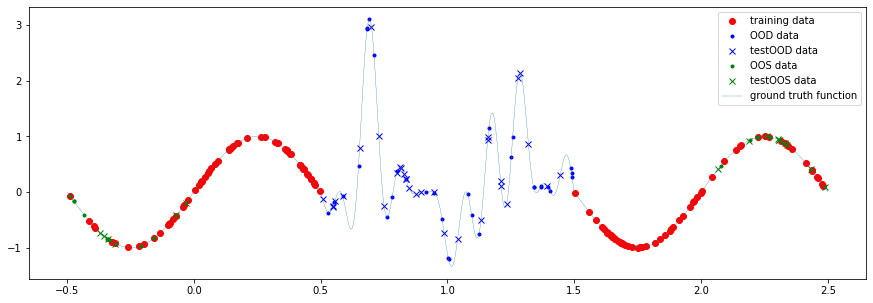

In [2]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 32, 64, seed=7, plot=True, device='cuda', shuffle=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [3]:
#main_net = nn.Sequential(nn.Linear(1, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 256))

class main_net(nn.Module):
    def __init__(self, width=256):
        super().__init__()
        self.x_layer = nn.Linear(1, width)
        self.hidden_layer_1 = nn.Linear(width, width)
        self.hidden_layer_2 = nn.Linear(width, width)
    
    def forward(self, x, noise_1=None, noise_2=None):
        out = F.relu(self.x_layer(x))
        if noise_1 is not None:
            out = F.relu(self.hidden_layer_1(out)) * noise_1
        else:
            out = F.relu(self.hidden_layer_1(out))
        return self.hidden_layer_2(out) * noise_2 if noise_2 is not None else self.hidden_layer_2(out)

class noise_net(nn.Module):
    def __init__(self, noise_dim, width=256):
        super().__init__()
        self.noise_layer = nn.Linear(noise_dim, width, bias=False)
        self.x_layer = nn.Linear(1, width, bias=True)
        self.hidden_layer_1 = nn.Linear(width, width, bias=True)
        self.hidden_layer_2 = nn.Linear(width, width, bias=False)
        self.output_layer = nn.Linear(width, 256, bias=False)
    
    def forward(self, x, noise):
        #out = F.relu(self.x_layer(x))
        #out = F.relu(self.hidden_layer_1(out)) * self.noise_layer(noise)
        out = F.relu(self.noise_layer(noise))
        out = F.relu(self.hidden_layer_1(out))
        out = F.relu(self.hidden_layer_2(out))
        return 1+self.output_layer(out)

output_net = nn.Sequential(nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1))



In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(x, y)

#optimizer = torch.optim.Adam(itertools.chain(mu.parameters(), out.parameters()), lr=0.002)
#optimizer = torch.optim.Adam(itertools.chain(mu.parameters(),
#                                             out.parameters()), lr=0.002)
loss_fn = nn.MSELoss()


def train_mu(mu, sigma_1, sigma_2, out, optimizer, loss_fn, loader):
    gamma = 0.5
    losses = []
    for epoch in range(500):
        epoch_losses = []
        for batch_id, (xi, yi) in enumerate(loader):
            optimizer.zero_grad()

            # E_Z(F(x, Z)) == \mu(x)
            z = torch.randn(len(xi), noise_dim).cuda()
            y_hat = out(mu(xi, sigma_1(xi, z), sigma_2(xi, z))) # * sigma(xi, z)

            # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
            '''
            z_prime = torch.randn(len(xi) // 2, 10).cuda()
            xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
            yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
            mu_1 = out(mu(xi_1))
            mu_2 = out(mu(xi_2))
            r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime)) - mu_1
            r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
            r_1 = yi_1 - mu_1
            r_2 = yi_2 - mu_2
            '''
            f_loss = loss_fn(y_hat, yi) #+ gamma * loss_fn(r_hat_1*r_hat_2, r_1*r_2)
            epoch_losses.append(f_loss.item() * xi.shape[0])
            f_loss.backward()
            optimizer.step()
        losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
    return losses

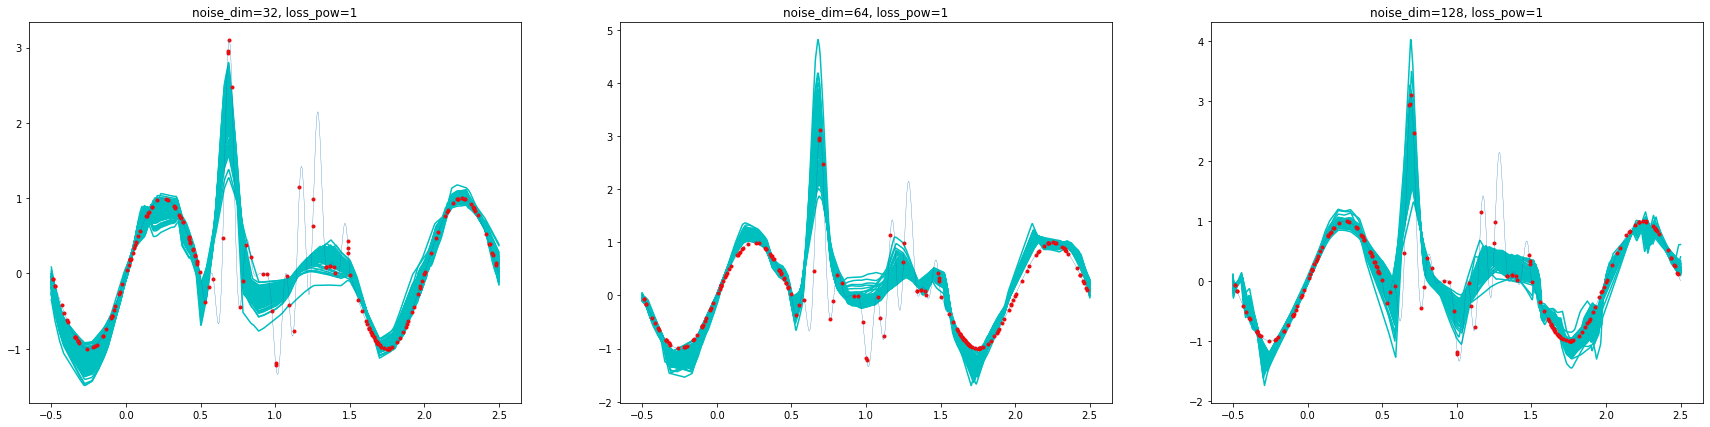

In [11]:
plt.figure(figsize=(30, 7))

plot_i = 1
for noise_dim in [32, 64, 128]:
    for loss_pow in [1]: #, 2, 3]:
        
        plt.subplot(1, 3, plot_i)
        
        mu = main_net().cuda()
        #sigma = noise_net().cuda()
        sigma_1 = noise_net(noise_dim=noise_dim, width=256).cuda()
        sigma_2 = noise_net(noise_dim=noise_dim, width=256).cuda()
        out = output_net.cuda()
        
        optimizer = torch.optim.Adam(itertools.chain(mu.parameters(),
                                                     sigma_1.parameters(),
                                                     sigma_2.parameters(),
                                                     out.parameters()), lr=0.002)
        loader = DataLoader(train_data, shuffle=True, batch_size=64)

        losses = train_mu(mu, sigma_1, sigma_2, out, optimizer, loss_fn, loader)
        
        optimizer = torch.optim.Adam(itertools.chain(sigma_1.parameters(), sigma_2.parameters()), lr=0.002)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x]), torch.cat([oos_y, ood_y, y]))
        deup_losses = []
        alpha = 1
        gamma = 1
        beta = 1
        loader = DataLoader(oos_data, shuffle=True, batch_size=128)
        for epoch in range(500):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()

                # E_Z(F(x, Z)) == \mu(x)
                z = torch.randn(len(xi), noise_dim).cuda()
                y_hat = out(mu(xi, noise_1=sigma_1(xi, z),
                                   noise_2=sigma_2(xi, z)))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
                yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
                mu_1 = out(mu(xi_1))
                mu_2 = out(mu(xi_2))
                r_hat_1 = out(mu(xi_1, noise_1=sigma_1(xi_1, z_prime),
                                       noise_2=sigma_2(xi_1, z_prime))) - mu_1
                r_hat_2 = out(mu(xi_2, noise_1=sigma_1(xi_2, z_prime),
                                       noise_2=sigma_2(xi_2, z_prime))) - mu_2
                r_1 = yi_1 - mu_1
                r_2 = yi_2 - mu_2

                #print(r_hat_1*r_hat_2, r_1*r_2)
                f_loss = alpha * loss_fn(y_hat, yi) + \
                         gamma * loss_fn((r_hat_1*r_hat_2)**loss_pow, (r_1*r_2)**loss_pow) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(100):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = out(mu(x_test, sigma_1(x_test, z),
                                              sigma_2(x_test, z))).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.plot(x_test.cpu(), y_test.squeeze().cpu(), label='ground truth function', linewidth=.3)
        plt.title(f'noise_dim={noise_dim}, loss_pow={loss_pow}')
        plot_i += 1

In [ ]:
plt.figure(figsize=(30, 20))

plot_i = 1

loss_pow = 3
noise_dim = 64
batch_size = 32
gamma = 1
beta = 1

for width in [128, 256, 512]:
    for lr in [0.0005, 0.001, 0.002]:
        plt.subplot(3, 3, plot_i)
        
        sigma = noise_net(noise_dim=noise_dim, width=width).cuda()
        optimizer = torch.optim.Adam(itertools.chain(sigma.parameters()), lr=lr)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x[:256]]), torch.cat([oos_y, ood_y, y[:256]]))
        deup_losses = []
        loader = DataLoader(oos_data, shuffle=True, batch_size=batch_size)
        for epoch in range(150):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()

                # E_Z(F(x, Z)) == \mu(x)
                #z = torch.randn(len(xi), noise_dim).cuda()
                #y_hat = out(mu(xi) * sigma(xi, z))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
                yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
                mu_1 = out(mu(xi_1))
                mu_2 = out(mu(xi_2))
                r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime))  - mu_1
                r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
                r_1 = yi_1 - mu_1
                r_2 = yi_2 - mu_2

                #print(r_hat_1*r_hat_2, r_1*r_2)
                f_loss = gamma * loss_fn((r_hat_1*r_hat_2)**loss_pow, (r_1*r_2)**loss_pow) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(20):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = (out(mu(x_test)*sigma(x_test, z))).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.title(f'width={width}, lr={lr}')
        plot_i += 1

In [ ]:
plt.plot(losses, label='train losses')
plt.plot(deup_losses, label='deup losses')
#plt.plot(valid_losses, label='valid losses')
plt.legend()

In [ ]:
plt.figure(figsize=(15, 5))
non_dropout_pred = out(mu(x_test)).detach()

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

for _ in range(100):
    z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
    non_dropout_pred = (out(mu(x_test))*sigma(x_test, z)).detach()
    plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
non_dropout_pred = sigma(x_test, z).detach()

plt.plot(torch.cat([oos_x,ood_x]).cpu(), torch.cat([oos_y,ood_y]).cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()